<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Loading" data-toc-modified-id="Data-Loading-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Loading</a></span></li><li><span><a href="#데이터-전처리" data-toc-modified-id="데이터-전처리-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>데이터 전처리</a></span></li><li><span><a href="#tokenizing" data-toc-modified-id="tokenizing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>tokenizing</a></span></li><li><span><a href="#Transformer-구현" data-toc-modified-id="Transformer-구현-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Transformer 구현</a></span><ul class="toc-item"><li><span><a href="#positional-encoding-layer" data-toc-modified-id="positional-encoding-layer-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>positional encoding layer</a></span></li><li><span><a href="#Scaled-Dot-Product-Attention" data-toc-modified-id="Scaled-Dot-Product-Attention-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Scaled-Dot Product Attention</a></span></li><li><span><a href="#MultiHeadAttention" data-toc-modified-id="MultiHeadAttention-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>MultiHeadAttention</a></span></li><li><span><a href="#Padding-masking" data-toc-modified-id="Padding-masking-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Padding masking</a></span></li><li><span><a href="#Look-ahead-masking" data-toc-modified-id="Look-ahead-masking-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Look-ahead masking</a></span></li><li><span><a href="#Encoder" data-toc-modified-id="Encoder-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Encoder</a></span></li><li><span><a href="#Decoder" data-toc-modified-id="Decoder-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Decoder</a></span></li><li><span><a href="#3.-교사-강요(Teacher-Forcing)-사용하기" data-toc-modified-id="3.-교사-강요(Teacher-Forcing)-사용하기-4.8"><span class="toc-item-num">4.8&nbsp;&nbsp;</span>3. 교사 강요(Teacher Forcing) 사용하기</a></span></li></ul></li><li><span><a href="#모델-정의-및-학습하기" data-toc-modified-id="모델-정의-및-학습하기-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>모델 정의 및 학습하기</a></span><ul class="toc-item"><li><span><a href="#모델-생성" data-toc-modified-id="모델-생성-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>모델 생성</a></span></li><li><span><a href="#손실함수" data-toc-modified-id="손실함수-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>손실함수</a></span></li><li><span><a href="#커스텀-된-학습률(Learning-rate)" data-toc-modified-id="커스텀-된-학습률(Learning-rate)-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>커스텀 된 학습률(Learning rate)</a></span></li><li><span><a href="#모델컴파일" data-toc-modified-id="모델컴파일-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>모델컴파일</a></span></li></ul></li><li><span><a href="#훈련하기" data-toc-modified-id="훈련하기-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>훈련하기</a></span></li><li><span><a href="#챗봇-테스트하기" data-toc-modified-id="챗봇-테스트하기-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>챗봇 테스트하기</a></span></li><li><span><a href="#회고" data-toc-modified-id="회고-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>회고</a></span></li></ul></div>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Data Loading

In [2]:
data = pd.read_csv('ChatbotData .csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


# 데이터 전처리

In [3]:
#re.sub(pattern[정규식], repl[치환할문자열], string[src문자열], count=0, flags=0)
# pattern 문자열에서 \ 문자를 사용하는 경우에는 혹시 모를 오류를 방지하기 위해 pattern을 raw string으로 변경

# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 , 끝에는 를 추가합니다
#     7. 띄어쓰기 단위로 문장을 분리

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() #1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) #2 
    sentence = re.sub(r'[" "]+', " ", sentence) #3
    #sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence) #4
    
    sentence = sentence.strip() #5
    #sentence = sentence.split(" ") # 7
    
    return sentence

print(preprocess_sentence("This @_is ;;;sample        sentence."))
print(preprocess_sentence('힘든 연애 좋은 연애라는게 무슨 차이일까?'))

this @_is ;;;sample sentence .
힘든 연애 좋은 연애라는게 무슨 차이일까 ?


In [4]:
# def load_conversations(data_q, data_a):

#     inputs = data.Q.apply(lambda data_q : preprocess_sentence(data_q))
#     outputs = data.A.apply(lambda data_a : preprocess_sentence(data_a))
    
#     return inputs, outputs

# questions, answers = load_conversations(data.Q, data.A)

In [5]:
# 제안된 함수사용과 달리 기존학습에서 적용하였던 아래와 같은 코드로 수정하여 질문과 대답을 분리
questions = data.Q.apply(lambda data_q : preprocess_sentence(data_q))
answers = data.A.apply(lambda data_a : preprocess_sentence(data_a))
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [6]:
questions

0                         12시 땡 !
1                     1지망 학교 떨어졌어
2                    3박4일 놀러가고 싶다
3                 3박4일 정도 놀러가고 싶다
4                         ppl 심하네
                   ...           
11818             훔쳐보는 것도 눈치 보임 .
11819             훔쳐보는 것도 눈치 보임 .
11820                흑기사 해주는 짝남 .
11821    힘든 연애 좋은 연애라는게 무슨 차이일까 ?
11822                  힘들어서 결혼할까봐
Name: Q, Length: 11823, dtype: object

In [7]:
answers

0                      하루가 또 가네요 .
1                       위로해 드립니다 .
2                     여행은 언제나 좋죠 .
3                     여행은 언제나 좋죠 .
4                      눈살이 찌푸려지죠 .
                   ...            
11818          티가 나니까 눈치가 보이는 거죠 !
11819               훔쳐보는 거 티나나봐요 .
11820                      설렜겠어요 .
11821    잘 헤어질 수 있는 사이 여부인 거 같아요 .
11822          도피성 결혼은 하지 않길 바라요 .
Name: A, Length: 11823, dtype: object

In [8]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


# tokenizing
    SubwordTextEncoder 사용하기

In [9]:
# 각 단어에 고유한 정수 인덱스 부여
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [10]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# vocab은 0~ 8363, STRART_TOKEN: 8364, END_TOKEN: 8365
print('1. START_TOKEN의 번호 :' ,[tokenizer.vocab_size]) 
print('2. END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print("3. VOCAB_SIZE: ", VOCAB_SIZE)

# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('4. 정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('5. 정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print("6. MAX_LENGTH: ", MAX_LENGTH)

1. START_TOKEN의 번호 : [8364]
2. END_TOKEN의 번호 : [8365]
3. VOCAB_SIZE:  8366
4. 정수 인코딩 후의 21번째 질문 샘플: [5828, 605, 2500, 4174]
5. 정수 인코딩 후의 21번째 답변 샘플: [2685, 7669, 8, 6378, 95, 1]
6. MAX_LENGTH:  40


In [11]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(questions, answers):
  tokenized_inputs, tokenized_outputs = [], []

  # zip(): 원소를 터플의 형태로 차례로 접근할 수 있는 반복자(iterator)를 반환  
  for (sentence1, sentence2) in zip(questions, answers):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8366
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


# Transformer 구현

## positional encoding layer

In [12]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


행의 크기가 50, 열의 크기가 512인 행렬 (최대 문장의 길이가 50이고 워드 임베딩 차원을 512로 하는 모델)

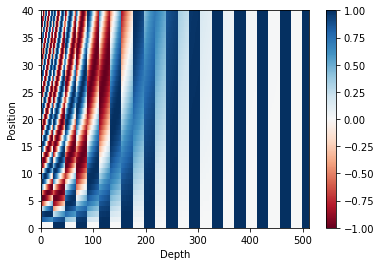

In [13]:
sample_pos_encoding = PositionalEncoding(40, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Scaled-Dot Product Attention
어텐션을 수행한다고 한다면, 스케일드 닷 프로덕트 어텐션을 의미

In [14]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True) # If True, b(key) is transposed before multiplication.

  # 가중치를 정규화-(루트로 나눠주는 부분}
  # https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/api_docs/python/array_ops.html
  depth = tf.cast(tf.shape(key)[-1], tf.float32) # shape를 '[-1]'로 하여 'key'를 1-D로 펴기
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가, 마스크 행렬을 이용해 특정단어는 무시할 수 있도록 함
  # 정규화 후 logits값에 마스크를 씌워 (마스크 값으로 음수 무한의 값을 넣어) softmax함수의 출력이 0%에 가까워지도록 한다.
  if mask is not None:
    logits += (mask * -1e9)
  # softmax의 음수 무한의 값은 0으로 수렴.
  
  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


## MultiHeadAttention

![attention](../songys_chatbot/images/linear_layer.png)

![attention](../songys_chatbot/images/split.png)

In [15]:
# https://machinelearningmastery.com/how-to-implement-multi-head-attention-from-scratch-in-tensorflow-and-keras/
# https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853
# 하나의 later를 생성 후 Sigle matrix operation을 수행 (rather than requiring N seperate operations) This makes the 
# computations more efficient and keeps the model simple because fewer Linear layers are required, 
# while still achieving the power of the independent Attention heads.

# tf.keras.layers.Layer class를 부모 class로 하여 MultiHeadAttention자식객체를 생성하여 상속받는다.
# super()의 인자로는 두 개가 전달되며, 하위클래스의 이름과 하위클래스의 객체(object)가 필요
# https://supermemi.tistory.com/178
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name) 
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0
    # assert [조건식], [메시지]
    # 정수가 아니면 error 발생메시지
    
    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model) # Learned projection matrix for the queries
    self.key_dense = tf.keras.layers.Dense(units=d_model) # Learned projection matrix for the keys
    self.value_dense = tf.keras.layers.Dense(units=d_model) # Learned projection matrix for the values

    self.dense = tf.keras.layers.Dense(units=d_model) # Learned projection matrix for the multi-head output


    # 레이어 (배치 크기, 시퀀스 길이, 쿼리/키/값 치수)
    # Rearrange the queries, keys, values to be able to compute all heads in parallel
    #  tf.transpose(전치할 행렬, 차원의 순서, [오퍼레이션 명칭])
    # 만약 shape의 한 원소가 -1이라면, 전체 크기가 일정하게 유지되도록 해당 차원의 길이가 자동으로 계산
    # https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth)) # seq는 -1값으로 자동으로 계산
    return tf.transpose(inputs, perm=[0, 2, 1, 3]) # head와 seq의 위치를 바꿔좀으로써 input shape과 동일하게 만들 수 있음
    #axis0=batch_size
    #axis1=-1(seq)
    #axis2=num_heads
    #axis3=depth
    #transpose [0,2,1,3]
    # (batch_size, num_heads, seq, depth) 순으로 치환됨
    
  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다, 
    # The input is passed through these Linear layers to produce the Q, K, and V matrices.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # Q, K, V에 각각 Dense를 적용 후 병렬 연산을 위해 나누기 
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    # reshape의 목적은 head dimention을 제거하기위함으로  Head*Query size를 행렬곱하여  
    # d_model(최초의 차원)으로 만들기위함이다.
    # (batch_size, seq, Head*Query size= embedding size(d_model))의 형태로 ...
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에는 연결된 행렬에 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


## Padding masking

In [16]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


## Look-ahead masking 
    다음 단어 가리기)

In [17]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


## Encoder

In [18]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
# units = d_model인데 왜 변수가 중복필요한건지?
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  #문장길이가 다를때 padding을 하여 문장의 길이를 동일하게해줌, 하지만 이는 불필요한 숫자이므로 참고하지 않을 수 있게 패딩 마스크를 사용해야한다
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)  # skip-connection
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs) # skip-connection
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [19]:
tf.keras.Model

keras.engine.training.Model

In [20]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # inputs: a Tensor. The input data to TransformerEncoder, should be of shape [batch_size, sequence_length, feature_dim].
  #문장길이가 다를때 padding을 하여 문장의 길이를 동일하게해줌, 하지만 이는 불필요한 숫자이므로 참고하지 않을 수 있게 패딩 마스크를 사용해야한다
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


## Decoder
    디코더는 인코더와 비슷하지만, 인코더보다 조금 더 복잡합니다. 인코더는 두 개의 서브 층으로 구성되지만, 디코더는 세 개의 서브 층으로 구성된다는 점이 다릅니다.

In [21]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, #디코더의 attention1
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [22]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


## 3. 교사 강요(Teacher Forcing) 사용하기
    교사 강요(teacher forcing)란, 테스트 과정에서 t 시점의 출력이 t+1 시점의 입력으로 사용되는 RNN 모델을 훈련시킬 때 사용하는 훈련 기법

In [23]:
import tensorflow_datasets as tfds
#질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성
#이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용

BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1: ]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


# 모델 정의 및 학습하기

In [24]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


## 모델 생성
    num_layers, d-Model, units는 전부 사용자가 정할 수 있는 하이퍼파라미터 값

In [25]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3195904     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## 손실함수

In [26]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


## 커스텀 된 학습률(Learning rate)

In [27]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

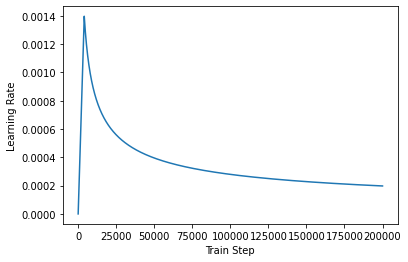

In [28]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 모델컴파일

In [31]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


# 훈련하기

In [34]:
# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [35]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)


Epoch 1/10
185/185 [==============================] - 10s 53ms/step - loss: 1.1522 - accuracy: 0.0495
Epoch 2/10
185/185 [==============================] - 10s 53ms/step - loss: 0.9941 - accuracy: 0.0508
Epoch 3/10
185/185 [==============================] - 10s 53ms/step - loss: 0.9221 - accuracy: 0.0550
Epoch 4/10
185/185 [==============================] - 10s 53ms/step - loss: 0.8641 - accuracy: 0.0580
Epoch 5/10
185/185 [==============================] - 10s 53ms/step - loss: 0.8036 - accuracy: 0.0625
Epoch 6/10
185/185 [==============================] - 10s 54ms/step - loss: 0.7359 - accuracy: 0.0689
Epoch 7/10
185/185 [==============================] - 10s 53ms/step - loss: 0.6626 - accuracy: 0.0767
Epoch 8/10
185/185 [==============================] - 10s 54ms/step - loss: 0.5832 - accuracy: 0.0854
Epoch 9/10
185/185 [==============================] - 10s 54ms/step - loss: 0.5011 - accuracy: 0.0947
Epoch 10/10
185/185 [==============================] - 10s 54ms/step - loss: 0.418

# 챗봇 테스트하기
    예측(inference) 단계

    1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
    2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
    3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
    4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
    5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
    6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [36]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [37]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [40]:
sentence_generation('AI는 좋아?')

입력 : AI는 좋아?
출력 : 나쁜 사람이네요 .


'나쁜 사람이네요 .'

In [39]:
sentence_generation("세상에 종말이 올까?")

입력 : 세상에 종말이 올까?
출력 : 제가 있잖아요 .


'제가 있잖아요 .'

# 회고
    1. 개인적인 견해로, Transformer 의 Attention Algorithm에 대한 이해도는, "문제에서 답을 찾자" 라는 현실세계의 문제인식과 해결책을 모색하는 방법과 비슷한게 아닐까한다. RNN과 같이 "원인에 따라 결과를 도출" 하는 순차적인 접근을 하는 것과는 분명히 접근법에 차이가 있는 것 같다. 현실세계에서도 다양한 상황에 따라 두 방법이 모두 사용되듯이 딥러닝에서도 상황에따른 적절한 모델을 선정하는 것이 중요할 듯하다.  
    
    2. 질문에 대한 답변이 구체적이지는 않지만 맥락을 어느정도 파악하여 답변을 하고 있다. 맥락을 완벽히 파악하지 못하여 유머러스하게 보이는 경향이 있음. 차원을 늘려 깊게 학습을 시킬 경우 맥락을 파악하는 깊이도 발전할 듯하다. 
        
    ref) 아래의 기술블로그를 통해 transformer의 상세 프로세스를 이해하는데 도움을 받았다.
    1. https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853